In [1]:
# podman run -d --name some-postgres -p5432:5432 -e POSTGRES_DB=demand_data -e POSTGRES_USER=user -e POSTGRES_PASSWORD=pass -e PGDATA=/var/lib/postgresql/data/pgdata -v postgres_data:/var/lib/postgresql/data  postgres

In [2]:
from collections import defaultdict
import os
import random
from pprint import pprint
import warnings


import tsfresh
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters

import datasets
import models

warnings.simplefilter(action="ignore", category=FutureWarning)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    MultiLabelBinarizer,
    OneHotEncoder,
    StandardScaler,
)

# from sklearnex import patch_sklearn
from torch import nn, optim
from tqdm.notebook import tqdm

# patch_sklearn()
tqdm.pandas()
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Using 1 year of history data (52 weeks)
window = 52
# Predicting out 8 weeks
n_out = 16
# early_stop = {"patience": 15, "min_delta": 0.5 * (window * 2) / 10}
resample_period = "1W"
dataset_type = "df_sales"
# Retain only SKU that have at least 10% of data [(1 - max_zeros_in_sku) * 100]
max_zeros_in_sku = 0.7

/opt/SP/SDK/miniforge3/envs/ml/lib/python3.12/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv("sklearnFakeData_v2.csv")
df["date"] = pd.to_datetime(df["date"])
df.rename(columns={"product_id": "sku", "sales_qty": "qty"}, inplace=True)
df.set_index("date", inplace=True)
# Just for test purpose. No meaning in the data-generator
del df["stock"]
del df["price"]
df = df.convert_dtypes()
print(df.dtypes)
display(df)

store_id        string[python]
sku             string[python]
qty                      Int64
discount               Float64
is_promo_day           boolean
color           string[python]
size            string[python]
category        string[python]
subcategory     string[python]
dtype: object


store_id         sku  qty  discount  is_promo_day  color size  \
date                                                                        
2020-01-01   store_4   product_0   24      0.01         False    red    S   
2020-01-01   store_7  product_32    0      0.05         False    red    S   
2020-01-01  store_12  product_69    0      0.02         False  black   XL   
2020-01-01  store_18  product_88    0      0.01          True    red    S   
2020-01-01  store_10  product_45  129      0.03         False  white    L   
...              ...         ...  ...       ...           ...    ...  ...   
2023-12-30   store_2  product_66    0      0.06         False  green    S   
2023-12-30  store_11  product_66   76      0.06         False  green    S   
2023-12-30  store_15  product_66    0      0.06          True  green    S   
2023-12-30   store_7  product_66   54      0.06          True  green    S   
2023-12-30   store_5  product_99    5      0.07         False   blue    S   

           category subcategory  
date                             
2020-01-01  costume           C  
2020-01-01  costume           C  
2020-01-01    socks           B  
2020-01-01    shoes           F  
2020-01-01    dress           C  
...             ...         ...  
2023-12-30    shoes           E  
2023-12-30    shoes           E  
2023-12-30    shoes           E  
2023-12-30    shoes           E  
2023-12-30  costume           A  

[2920000 rows x 9 columns]

In [5]:
series_list = []
for _, _df in tqdm(df.groupby(["sku", "store_id"])):
    agg = dict(zip(_df.keys(), ["last"] * len(_df.columns))) | {"qty": "sum"}
    # FIXME: Manage nil entries
    _series = _df.resample(resample_period).agg(agg)
    # _series.fillna(0,inplace=True)
    series_list.append(_series)
series = pd.concat(series_list).sort_index()
print(
    f"Resampled {len(df)} entries ({df['sku'].nunique()} total products) into {len(series)} entries"
)

  0%|          | 0/1263 [00:00<?, ?it/s]

Resampled 2920000 entries (100 total products) into 263967 entries


In [6]:
mask = series.select_dtypes("string").isna().any(axis=1)
print(
    f"Removing {len(series.loc[mask, 'sku'].unique())} SKU that does not have categorical data [{mask.sum()}] weeks"
)
series = series[~mask].copy()

Removing 0 SKU that does not have categorical data [0] weeks


In [7]:
# Removing SKUs that do not have at least:
# - 1 example for train and 1 for test
# - 90% of empty data


def filter_sku(df):
    """Filters a single product based on length and zero percentage."""
    if len(df) < (window + n_out + 2):
        return False  # Too short
    zero_percentage = (df["qty"] == 0).sum() / len(df)
    return zero_percentage < max_zeros_in_sku


filter_fields = ["sku", "store_id"]
entries_to_retain = (
    series.groupby(filter_fields)
    .filter(filter_sku)[filter_fields]
    .reset_index(drop=True)
    .drop_duplicates()
)
# Retain only filtered sku-stores
index = series.index
series = series.merge(entries_to_retain, on=filter_fields, how="inner")
series.index = index
series

store_id         sku   qty  discount  is_promo_day  color size  \
date                                                                         
2020-01-05   store_0   product_0    39      0.05          True    red    S   
2020-01-05   store_4  product_71  2708      0.02         False   blue    M   
2020-01-05  store_16  product_35  1343      0.05         False  black    L   
2020-01-05   store_9  product_21   961       0.0         False  green    M   
2020-01-05   store_1  product_57   495      0.01         False    red    L   
...              ...         ...   ...       ...           ...    ...  ...   
2023-12-31  store_11  product_10   850       0.0         False   blue   XL   
2023-12-31  store_13  product_18  4934      0.01         False  white    S   
2023-12-31   store_2   product_9     0      0.04         False  black    L   
2023-12-31   store_4   product_9   411      0.04         False  black    L   
2023-12-31   store_9  product_99    65      0.07         False   blue    S   

           category subcategory  
date                             
2020-01-05  costume           C  
2020-01-05    socks           A  
2020-01-05      bag           E  
2020-01-05     suit           A  
2020-01-05    dress           D  
...             ...         ...  
2023-12-31  costume           D  
2023-12-31      bag           B  
2023-12-31    socks           D  
2023-12-31    socks           D  
2023-12-31  costume           A  

[263967 rows x 9 columns]

In [8]:
sku_to_index = {sku: idx for idx, sku in enumerate(df["sku"].unique())}
series["sku_code"] = series["sku"].map(sku_to_index)
series = series.convert_dtypes()
series.dtypes

store_id        string[python]
sku             string[python]
qty                      Int64
discount               Float64
is_promo_day           boolean
color           string[python]
size            string[python]
category        string[python]
subcategory     string[python]
sku_code                 Int64
dtype: object

## Adding features using TSFresh

In [9]:
try:
    feature_df = pd.read_csv("metafeatures_minimal.csv")
except Exception:
    default_fc_params = MinimalFCParameters()
    metafeatures = {}
    for label, group in tqdm(series.groupby(["sku_code", "store_id"])):
        metafeatures[label] = tsfresh.extract_features(
            group.reset_index(),
            column_id="sku_code",
            column_value="qty",
            column_sort="date",
            disable_progressbar=True,
            default_fc_parameters=default_fc_params,
        )
    feature_df = pd.DataFrame(metafeatures.keys())
    tmp = pd.concat(metafeatures.values()).reset_index(drop=True)

    feature_df = pd.concat([feature_df, tmp], axis=1, ignore_index=True)
    feature_df.columns = ["sku_code", "store_id"] + list(tmp.columns)
    feature_df.to_csv("metafeatures_minimal.csv", index=False)
feature_df

sku_code  store_id  qty__sum_values  qty__median    qty__mean  \
0            0   store_0         355990.0       1339.0  1703.301435   
1            0   store_1         216365.0        880.0  1035.239234   
2            0  store_10         458274.0       1649.0  2192.698565   
3            0  store_11        1011700.0       4174.0  4840.669856   
4            0  store_12         304372.0       1156.0  1456.325359   
...        ...       ...              ...          ...          ...   
1258        99  store_16         394679.0       1800.0  1888.416268   
1259        99  store_17         107154.0        472.0   512.698565   
1260        99  store_18         283526.0       1316.0  1356.583732   
1261        99  store_19          92255.0        419.0   441.411483   
1262        99   store_6          95008.0        424.0   454.583732   

      qty__length  qty__standard_deviation  qty__variance  \
0           209.0              1497.371825   2.242122e+06   
1           209.0               863.135045   7.450021e+05   
2           209.0              1926.174827   3.710149e+06   
3           209.0              3150.605463   9.926315e+06   
4           209.0              1285.998545   1.653792e+06   
...           ...                      ...            ...   
1258        209.0               647.979808   4.198778e+05   
1259        209.0               248.500652   6.175257e+04   
1260        209.0               471.889163   2.226794e+05   
1261        209.0               206.753888   4.274717e+04   
1262        209.0               176.859861   3.127941e+04   

      qty__root_mean_square  qty__maximum  qty__absolute_maximum  qty__minimum  
0               2267.897300        6764.0                 6764.0           0.0  
1               1347.858441        4723.0                 4723.0           0.0  
2               2918.574388        9586.0                 9586.0           0.0  
3               5775.673073       15947.0                15947.0         100.0  
4               1942.852493        6447.0                 6447.0           0.0  
...                     ...           ...                    ...           ...  
1258            1996.495388        4209.0                 4209.0         738.0  
1259             569.747657        1393.0                 1393.0          60.0  
1260            1436.314312        2751.0                 2751.0         328.0  
1261             487.433347        1357.0                 1357.0          62.0  
1262             487.776363        1370.0                 1370.0         142.0  

[1263 rows x 12 columns]

## Clusterize the type of series.
We are going to "spawn" N regressor. One for each cluster

In [10]:
import utils

scaler = MinMaxScaler()
x = scaler.fit_transform(feature_df[feature_df.columns[2:]])
cluster_results = utils.find_best_k(x)
print("Optimal K:", cluster_results["best_k"])
kmeans = cluster_results["kmeans"]
feature_df["bins"] = kmeans.fit_predict(x)
bins = feature_df[["sku_code", "store_id", "bins"]]
feature_df.groupby("bins").size()

  0%|          | 0/28 [00:00<?, ?it/s]

Optimal K: 9


bins
0    878
1      9
2     43
3    195
4      6
5     37
6     11
7      1
8     83
dtype: int64

In [11]:
index = series.index
series = series.merge(
    feature_df[["sku_code", "store_id", "bins"]],
    on=["sku_code", "store_id"],
    how="inner",
)
series.index = index
series.head(5)

store_id         sku   qty  discount  is_promo_day  color size  \
date                                                                         
2020-01-05   store_0   product_0    39      0.05          True    red    S   
2020-01-05   store_4  product_71  2708      0.02         False   blue    M   
2020-01-05  store_16  product_35  1343      0.05         False  black    L   
2020-01-05   store_9  product_21   961       0.0         False  green    M   
2020-01-05   store_1  product_57   495      0.01         False    red    L   

           category subcategory  sku_code  bins  
date                                             
2020-01-05  costume           C         0     3  
2020-01-05    socks           A        55     3  
2020-01-05      bag           E        17     3  
2020-01-05     suit           A        35     0  
2020-01-05    dress           D        50     8

In [12]:
scalers = {}


def scale_data(group):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group.values.reshape(-1, 1))
    scalers[group.name] = scaler
    return scaled_data.flatten()


series["qty_scaled"] = series.groupby("bins")["qty"].transform(scale_data)
series = series.convert_dtypes()
series

store_id         sku   qty  discount  is_promo_day  color size  \
date                                                                         
2020-01-05   store_0   product_0    39      0.05          True    red    S   
2020-01-05   store_4  product_71  2708      0.02         False   blue    M   
2020-01-05  store_16  product_35  1343      0.05         False  black    L   
2020-01-05   store_9  product_21   961       0.0         False  green    M   
2020-01-05   store_1  product_57   495      0.01         False    red    L   
...              ...         ...   ...       ...           ...    ...  ...   
2023-12-31  store_11  product_10   850       0.0         False   blue   XL   
2023-12-31  store_13  product_18  4934      0.01         False  white    S   
2023-12-31   store_2   product_9     0      0.04         False  black    L   
2023-12-31   store_4   product_9   411      0.04         False  black    L   
2023-12-31   store_9  product_99    65      0.07         False   blue    S   

           category subcategory  sku_code  bins  qty_scaled  
date                                                         
2020-01-05  costume           C         0     3   -1.310356  
2020-01-05    socks           A        55     3    0.011734  
2020-01-05      bag           E        17     3   -0.664419  
2020-01-05     suit           A        35     0    0.678999  
2020-01-05    dress           D        50     8   -1.530371  
...             ...         ...       ...   ...         ...  
2023-12-31  costume           D        82     0    0.507618  
2023-12-31      bag           B        86     3    1.114384  
2023-12-31    socks           D        47     0   -0.804756  
2023-12-31    socks           D        47     0   -0.170184  
2023-12-31  costume           A        20     0   -0.704398  

[263967 rows x 12 columns]

## Timeseries creation

In [13]:
example_data = np.asarray(range(10))
print(example_data)
_x, _cat, _y = utils.create_timeseries(
    example_data, example_data, example_data, 3, 1, 0
)
print(train_test_split(_x, _cat, _y, shuffle=False))
_x.shape, _cat.shape, _y.shape, _x, _cat, _y

[0 1 2 3 4 5 6 7 8 9]
[array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]]), array([[4, 5, 6],
       [5, 6, 7]]), array([0, 1, 2, 3]), array([4, 5]), array([[3],
       [4],
       [5],
       [6]]), array([[7],
       [8]])]


((6, 3),
 (6,),
 (6, 1),
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7]]),
 array([0, 1, 2, 3, 4, 5]),
 array([[3],
        [4],
        [5],
        [6],
        [7],
        [8]]))

In [14]:
_max = 0
example_sku = ""
for sku, group in series.groupby("sku"):
    v = group["qty_scaled"].std() / group["qty_scaled"].max()
    if v > _max:
        example_sku = sku
        _max = v

mask = series["sku"] == example_sku
data = series.loc[mask, "qty_scaled"]
_data, has_outliers = utils.remove_outliers(data.astype(float), n=5)
plt.plot(data)
plt.plot(_data)

In [15]:
filtered_ts_fname = f"dataset/filtered_timeseries_{dataset_type}_{resample_period}_{max_zeros_in_sku}_{window}_{n_out}.parquet"
if os.path.exists(filtered_ts_fname):
    series = pd.read_parquet(filtered_ts_fname)
else:
    n_outliers = 0
    for sku in tqdm(series["sku"].unique()):
        mask = series["sku"] == sku
        data, has_outliers = utils.remove_outliers(series.loc[mask, "qty_scaled"], n=5)
        if has_outliers:
            n_outliers += 1
            series.loc[mask, "qty_scaled"] = data
    print(f"Removed {n_outliers} outliers")
    series = series.convert_dtypes()
    series.to_parquet(filtered_ts_fname, compression="brotli")

# Creating categorical features

In [16]:
cols = set(series.select_dtypes(np.number).columns)
# FIXME: Should discount be a class variable?
categorical_features = [c for c in series.columns if c not in cols and "sku" not in c]
categorical_features

['store_id', 'is_promo_day', 'color', 'size', 'category', 'subcategory']

In [17]:
label_encoders = {c: MultiLabelBinarizer() for c in categorical_features} | {
    # For boolean flag need to automatically get OneHot instead of label/multilabel
    "is_promo_day": OneHotEncoder(sparse_output=False, dtype=int),
    "store_id": OneHotEncoder(sparse_output=False, dtype=int),
}
label_encoders

{'store_id': OneHotEncoder(dtype=<class 'int'>, sparse_output=False),
 'is_promo_day': OneHotEncoder(dtype=<class 'int'>, sparse_output=False),
 'color': MultiLabelBinarizer(),
 'size': MultiLabelBinarizer(),
 'category': MultiLabelBinarizer(),
 'subcategory': MultiLabelBinarizer()}

In [18]:
for column, label_encoder in tqdm(label_encoders.items()):
    if "is_promo_day" in column or "store" in column:
        series[f"encoded_{column}"] = label_encoder.fit_transform(
            series[column].reset_index(drop=True).to_frame()
        ).tolist()
    else:
        series[f"encoded_{column}"] = label_encoder.fit_transform(
            series[column].reset_index(drop=True)
        ).tolist()

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
store_id_map = dict(
    pd.concat(
        [series["store_id"], series["encoded_store_id"].apply(lambda x: np.argmax(x))],
        axis=1,
    )
    .drop_duplicates()
    .values
)
store_id_map

{'store_0': 0,
 'store_4': 14,
 'store_16': 8,
 'store_9': 19,
 'store_1': 1,
 'store_18': 10,
 'store_17': 9,
 'store_19': 11,
 'store_3': 13,
 'store_12': 4,
 'store_6': 16,
 'store_14': 6,
 'store_8': 18,
 'store_13': 5,
 'store_15': 7,
 'store_11': 3,
 'store_5': 15,
 'store_10': 2,
 'store_2': 12,
 'store_7': 17}

In [20]:
utils.calculate_time_features(series)
utils.calculate_time_features(series, "future")

<Axes: xlabel='date'>

<Axes: xlabel='date'>

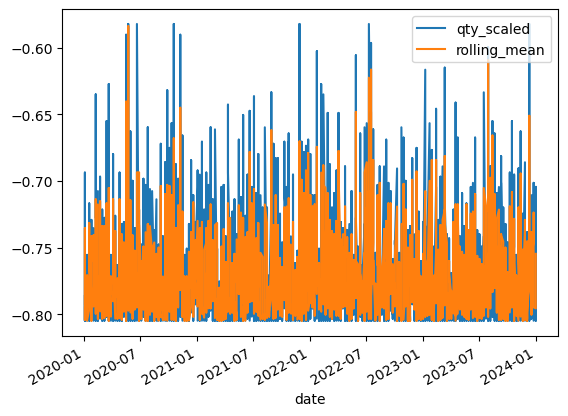

In [21]:
# Create time features. Decompose the time "signal" using cos and sin coordinates.
# By this, the first week of the year is nearest point of the last week instead of the farthest.
# FIXME: We use only the week number (1-53), add features related to holiday and month instead of the week number only)
# FIXME: Take care about the COVID period in order to add an external bias factor for influence the 2020-2022 sales.
#   Note that batch size can influence the generalization of the network and reduce the sales due to the decrease of the sales.


display(
    series[series["sku"] == sku][["p_t_sin", "p_t_cos", "p_m_sin", "p_m_cos"]].plot()
)
t = series[series["sku"] == sku][["qty_scaled"]]
t["rolling_mean"] = t["qty_scaled"].rolling(2).mean()
t.plot()

In [22]:
encoded_categorical_features = [
    c for c in series.columns if "encoded" in c and "bins" not in c
]
series_features = [
    "qty_scaled",
    "sku_code",
]
series_features.extend(
    [c for c in series.select_dtypes(np.number) if "cos" in c or "sin" in c]
)
raw_ds = {}
for label, group in tqdm(series.groupby("bins"), total=series["bins"].nunique()):
    raw_ds[label] = datasets.create_time_series_data(
        group, series_features, encoded_categorical_features, window=window, n_out=n_out
    )

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
(
    ts_train_x_dataset,
    ts_train_y_dataset,
    ts_train_cat_dataset,
    ts_test_x_dataset,
    ts_test_y_dataset,
    ts_test_cat_dataset,
) = raw_ds[0]
for x, cat, y in zip(ts_test_x_dataset, ts_test_cat_dataset, ts_test_y_dataset):
    print(x.shape, [_.shape for _ in cat], y.shape)
    break

(52, 10) [(20,), (2,), (15,), (4,), (15,), (6,)] (16,)


In [24]:
pin_memory = True
num_workers = 4
batch_size = 128
device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else torch.device("cpu")
)
metrics = models.init_metrics()

Skipping  ConcordanceCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  CriticalSuccessIndex CriticalSuccessIndex.__init__() missing 1 required positional argument: 'threshold'
Skipping  JensenShannonDivergence module 'torchmetrics' has no attribute 'JensenShannonDivergence'
Skipping  KendallRankCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  LogCoshError Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  MinkowskiDistance MinkowskiDistance.__init__() missing 1 required positional argument: 'p'
Skipping  PearsonCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.
Skipping  RelativeSquaredError output with shape [1] doesn't match the broadcast shape [4]
Skipping  SpearmanCorrCoef Expected argument `num_outputs` to match the second dimension of input, but got 1 and 4.


/opt/SP/SDK/miniforge3/envs/ml/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [25]:
train_dss = {}
test_dss = {}
train_dls = {}
test_dls = {}

for _bin, ds in raw_ds.items():
    x_train, y_train, x_cat_train, x_test, y_test, x_cat_test = ds
    dl_train, ds_train = datasets.init_ds(
        x=x_train,
        cat=x_cat_train,
        y=y_train,
        encoded_categorical_features=encoded_categorical_features,
        batch_size=batch_size,
        num_workers=num_workers,
        seed=seed,
        device=device,
    )
    dl_test, ds_test = datasets.init_ds(
        x=x_test,
        cat=x_cat_test,
        y=y_test,
        encoded_categorical_features=encoded_categorical_features,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        seed=seed,
        device=device,
    )

    # Torch module should name be a string :'(
    _bin = str(_bin)
    train_dls[_bin] = dl_train
    test_dls[_bin] = dl_test
    train_dss[_bin] = ds_train
    test_dss[_bin] = ds_test
total_examples_train = sum(
    [len(train_dss[f"{k}"]) for k in range(series["bins"].nunique())]
)
total_examples_test = sum(
    [len(test_dss[f"{k}"]) for k in range(series["bins"].nunique())]
)

total_examples_train, total_examples_test

(141456, 36627)

In [26]:
dls_train, dls_test = datasets.get_data(train_dls, test_dls)

In [27]:
for item in dls_train:
    key = list(item.keys())[0]
    data = item[key]
    break

In [28]:
encoded_features_shape = {}
for k, v in data.items():
    if k == "cats":
        encoded_features_shape.update({"cats": {k: _v.shape for k, _v in v.items()}})
    else:
        encoded_features_shape.update({k: v.shape})
pprint(encoded_features_shape)

{'cats': {'encoded_category': torch.Size([128, 15]),
          'encoded_color': torch.Size([128, 15]),
          'encoded_is_promo_day': torch.Size([128, 2]),
          'encoded_size': torch.Size([128, 4]),
          'encoded_store_id': torch.Size([128, 20]),
          'encoded_subcategory': torch.Size([128, 6])},
 'future_time': torch.Size([128, 16, 4]),
 'past_time': torch.Size([128, 52, 4]),
 'qty': torch.Size([128, 52, 1]),
 'sku': torch.Size([128]),
 'y': torch.Size([128, 16])}


In [29]:
encoded_features_shape = {}
for k, v in data.items():
    if k == "cats":
        encoded_features_shape.update(
            {"cats": {k: _v.shape[-1] for k, _v in v.items()}}
        )
    else:
        encoded_features_shape.update({k: v.shape[-1]})
pprint(encoded_features_shape)
sku_vocab_size = len(sku_to_index)
cat_features_shapes = encoded_features_shape["cats"]
time_features_dim = encoded_features_shape["past_time"]
qty_features_dim = encoded_features_shape["qty"]

{'cats': {'encoded_category': 15,
          'encoded_color': 15,
          'encoded_is_promo_day': 2,
          'encoded_size': 4,
          'encoded_store_id': 20,
          'encoded_subcategory': 6},
 'future_time': 4,
 'past_time': 4,
 'qty': 1,
 'sku': 128,
 'y': 16}


In [39]:
num_epochs = 10
model = models.ModelWrapper(
    series["bins"].nunique(),
    sku_vocab_size=sku_vocab_size,
    sku_emb_dim=32,
    cat_features_dim=cat_features_shapes,
    cat_emb_dims=32,
    past_time_features_dim=time_features_dim + qty_features_dim,
    future_time_features_dim=time_features_dim,
    d_model=256,
    nhead=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    dim_feedforward=2048,
    dropout=0.3,
    n_out=1,
    max_past_len=window,
    max_future_len=n_out,
)
model.to(device)

ModelWrapper(
  (models): ModuleDict(
    (0): AdvancedDemandForecastModel(
      (sku_embedding): Embedding(100, 32)
      (cat_embeddings): ModuleDict(
        (encoded_store_id): Embedding(20, 32)
        (encoded_is_promo_day): Embedding(2, 32)
        (encoded_color): Embedding(15, 32)
        (encoded_size): Embedding(4, 32)
        (encoded_category): Embedding(15, 32)
        (encoded_subcategory): Embedding(6, 32)
      )
      (static_proj): Linear(in_features=224, out_features=256, bias=True)
      (past_proj): Linear(in_features=5, out_features=256, bias=True)
      (future_proj): Linear(in_features=4, out_features=256, bias=True)
      (pos_enc): PositionalEncoding()
      (dec_pos_enc): PositionalEncoding()
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=T

In [40]:
# for item in dls_train:
#     key = list(item.keys())[0]
#     batch = item[key]
#     break
# qty = batch["qty"]
# past_time = batch["past_time"]
# future_time = batch["future_time"]
# sku = batch["sku"]
# # Maybe it is not necessary. To save memory, we save the categorical matrix data as boolean (True/False instead of 1/0)
# cats = {key: value.to(dtype=torch.int32) for key, value in batch["cats"].items()}
# # y_class = torch.argmax(batch["y_cat"], dim=-1)  # [batch_size, n_out]
# targets = batch["y"]
# # Forward pass return both regression and classification
# outputs = model(key, qty, past_time, future_time, sku, cats)
# del qty, past_time, future_time, sku, cats, batch, item
# utils._collect()
# outputs

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1105 [00:00<?, ?it/s]

Epoch [1/10], Loss: 17.8300


  0%|          | 0/286 [00:00<?, ?it/s]

Validation Results:
Loss: 13.1298 MSE: 0.5760 MAE: 0.4952 FLAT_MSE: 12.9213 FLAT_MAE: 2.4705


  0%|          | 0/1105 [00:00<?, ?it/s]

Epoch [2/10], Loss: 11.8653


  0%|          | 0/286 [00:00<?, ?it/s]

Validation Results:
Loss: 11.8180 MSE: 0.5706 MAE: 0.4947 FLAT_MSE: 11.6495 FLAT_MAE: 2.2948


  0%|          | 0/1105 [00:00<?, ?it/s]

Epoch [3/10], Loss: 11.4740


  0%|          | 0/286 [00:00<?, ?it/s]

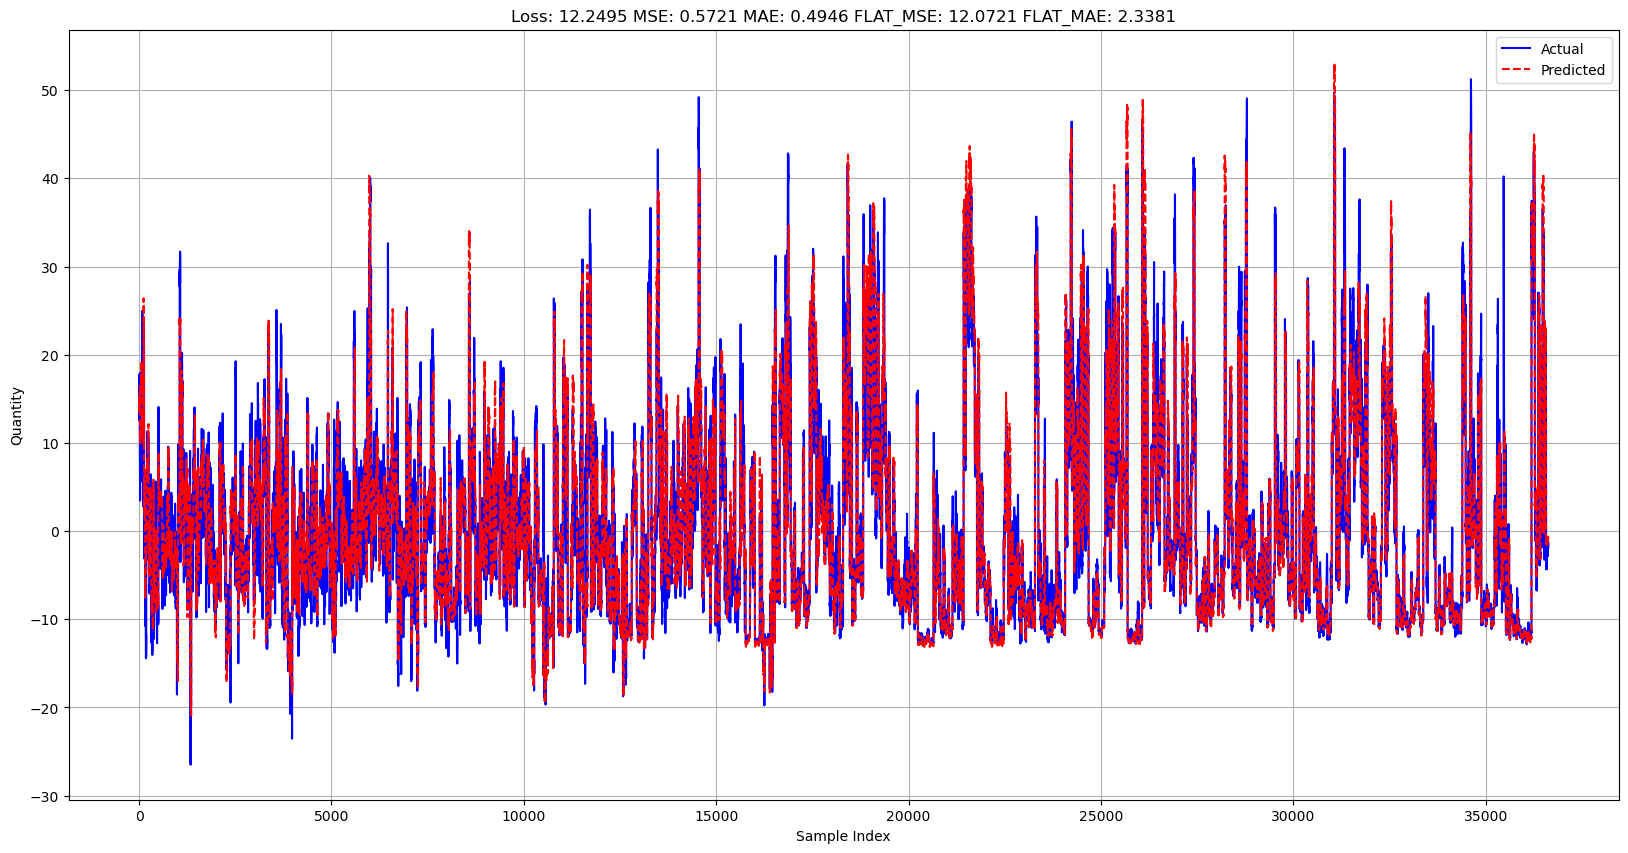

Validation Results:
Loss: 12.2495 MSE: 0.5721 MAE: 0.4946 FLAT_MSE: 12.0721 FLAT_MAE: 2.3381


  0%|          | 0/1105 [00:00<?, ?it/s]

Epoch [4/10], Loss: 11.2442


  0%|          | 0/286 [00:00<?, ?it/s]

Validation Results:
Loss: 12.8273 MSE: 0.5744 MAE: 0.4947 FLAT_MSE: 12.6805 FLAT_MAE: 2.4835


  0%|          | 0/1105 [00:00<?, ?it/s]

Epoch [5/10], Loss: 11.0395


  0%|          | 0/286 [00:00<?, ?it/s]

Validation Results:
Loss: 12.7360 MSE: 0.5740 MAE: 0.4948 FLAT_MSE: 12.5905 FLAT_MAE: 2.5618
Early stopping triggered after 5 epochs!


In [41]:
# for batch in dls_train:
#     key = list(item.keys())[0]
#     batch = item[key]

#     dot = utils.plot_model(model, batch)
#     dot.format = "svg"
#     dot.render()
#     del batch
#     break


# Define the loss functions and optimizer
flatten = True
early_stop = {"patience": 3, "min_delta": 1 if flatten else 0.1}
regression_criterion = nn.MSELoss()
optimizers = {
    f"{i}": optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-2)
    for i in range(series["bins"].nunique())
}
schedulers = {
    f"{i}": optim.lr_scheduler.CosineAnnealingLR(optimizers[f"{i}"], T_max=num_epochs)
    for i in range(series["bins"].nunique())
}

utils._collect()

models.train_model(
    models=model,
    dataloader_train=train_dls,
    dataloader_test=test_dls,
    regression_criterion=regression_criterion,
    optimizers=optimizers,
    schedulers=schedulers,
    num_epochs=num_epochs,
    batch_size=batch_size,
    early_stop=early_stop,
    total_examples_train=total_examples_train,
    total_examples_test=total_examples_test,
    flatten=flatten,
    metrics=metrics,
)
# Epoch [1/50], Loss: 16.4140
# Validation Results:
# Loss: 6.7574 MSE: 0.2700 MAE: 0.2440 FLAT_MSE: 6.0259 FLAT_MAE: 1.3423
# Epoch [2/50], Loss: 8.7507
# Validation Results:
# Loss: 7.4211 MSE: 0.2694 MAE: 0.2407 FLAT_MSE: 6.6840 FLAT_MAE: 1.1954
# Epoch [3/50], Loss: 7.4390
# Validation Results:
# Loss: 6.9139 MSE: 0.2653 MAE: 0.2373 FLAT_MSE: 6.1953 FLAT_MAE: 1.0522
# Epoch [4/50], Loss: 7.4061

In [42]:
def calculate_confidence_intervals(predictions, y, confidence=0.95):
    if not isinstance(y, torch.Tensor):
        y = torch.from_numpy(y)
    if not isinstance(predictions, torch.Tensor):
        predictions = torch.from_numpy(predictions)

    if predictions.shape != y.shape:
        raise ValueError("Different shape of preds and labels")

    errors = y - predictions

    if errors.dim() > 1:
        std_devs = errors.std(dim=0)
    else:
        std_dev = torch.std(errors)
        std_devs = torch.full_like(predictions, std_dev)

    z = norm.ppf(1 - (1 - confidence) / 2)

    lower_bounds = predictions - (z * std_devs)
    upper_bounds = predictions + (z * std_devs)

    return lower_bounds, upper_bounds

  0%|          | 0/286 [00:00<?, ?it/s]

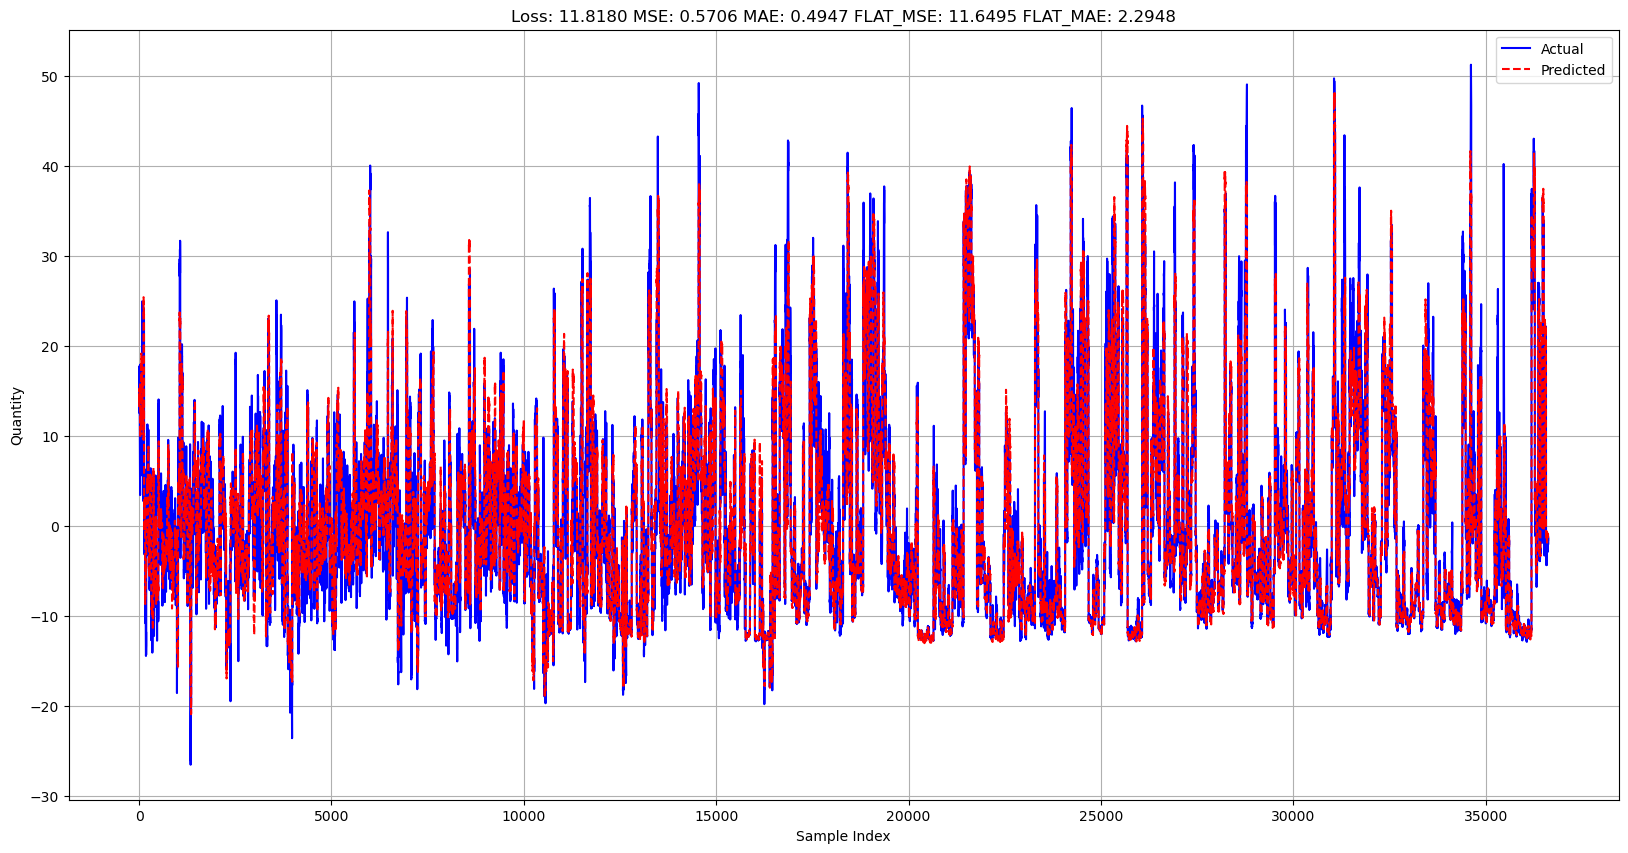

Validation Results:
Loss: 11.8180 MSE: 0.5706 MAE: 0.4947 FLAT_MSE: 11.6495 FLAT_MAE: 2.2948


In [43]:
# Validate the model on the test dataset
dls_train, dls_test = datasets.get_data(train_dls, test_dls)
val_metrics = models.validate_model(
    model,
    dls_test,
    regression_criterion,
    batch_size,
    total_examples_test,
    metrics,
    True,
)

In [44]:
score = round(val_metrics["metrics"]["MeanSquaredError"], 5)
torch.save(
    model,
    f"models/model_{flatten}_{score}_{window}_{n_out}.pt",
)

In [45]:
# predictions = scaler.inverse_transform(val_metrics["predictions"]).round()
# actuals = scaler.inverse_transform(val_metrics["actuals"]).round()
# FIXME: Understand how to scale due to the shuffling
predictions = val_metrics["predictions"]
actuals = val_metrics["actuals"]
flatten_predictions = np.sum(predictions, axis=-1)
flatten_actuals = np.sum(actuals, axis=-1)
d_preds = defaultdict(list)
sku_to_index_inv = {v: k for k, v in sku_to_index.items()}
for _pred, _y, _flatten_pred, _flatten_y, _sku in zip(
    predictions,
    actuals,
    flatten_predictions,
    flatten_actuals,
    [sku_to_index_inv[sku] for sku in val_metrics["skus"]],
):
    d_preds[_sku].append(
        {
            "preds": _pred,
            "y": _y,
            "flatten_preds": _flatten_pred,
            "flatten_y": _flatten_y,
            "preds_sum": _pred.sum(),
            "y_sum": _y.sum(),
        }
    )

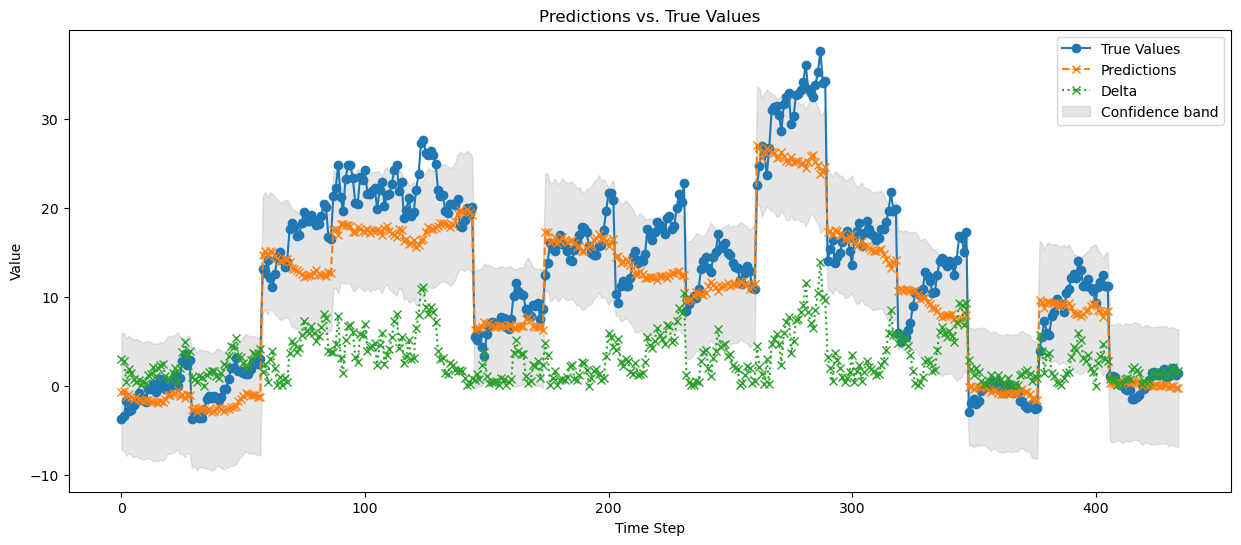

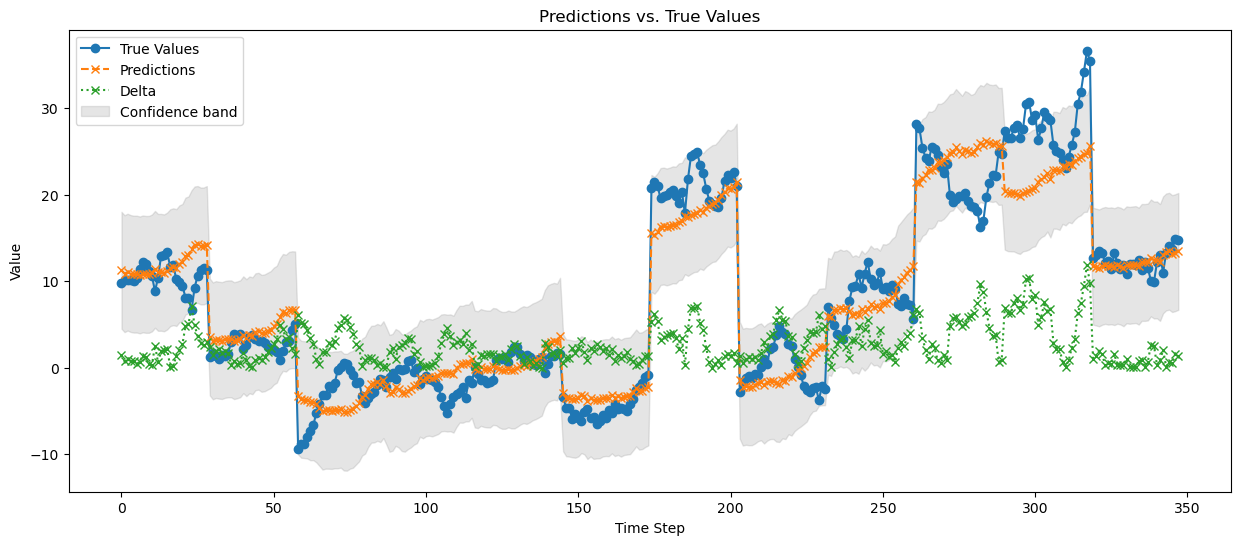

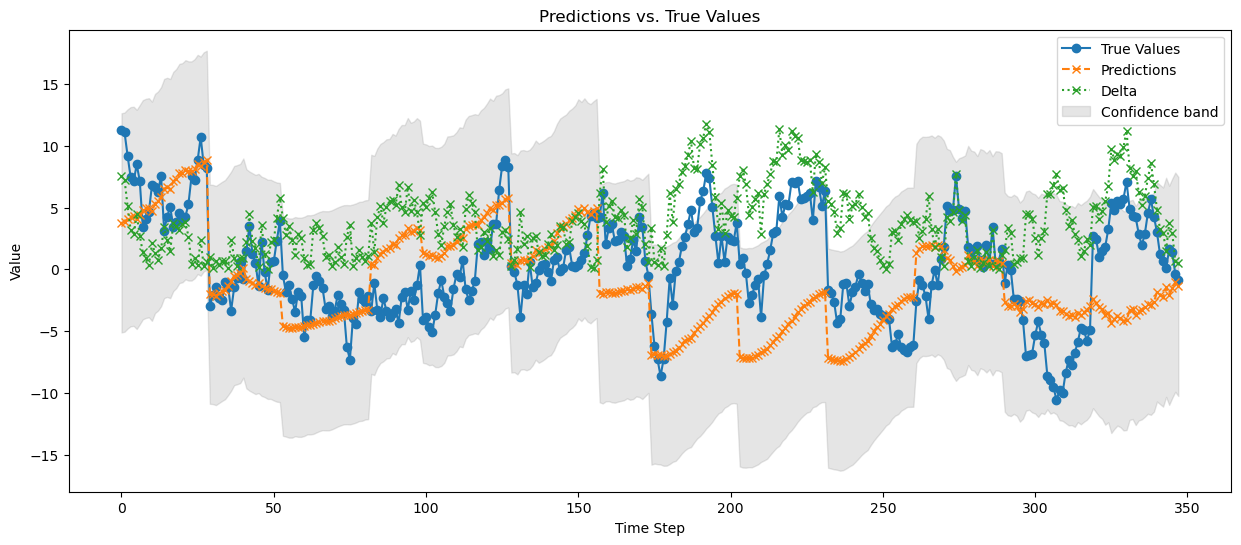

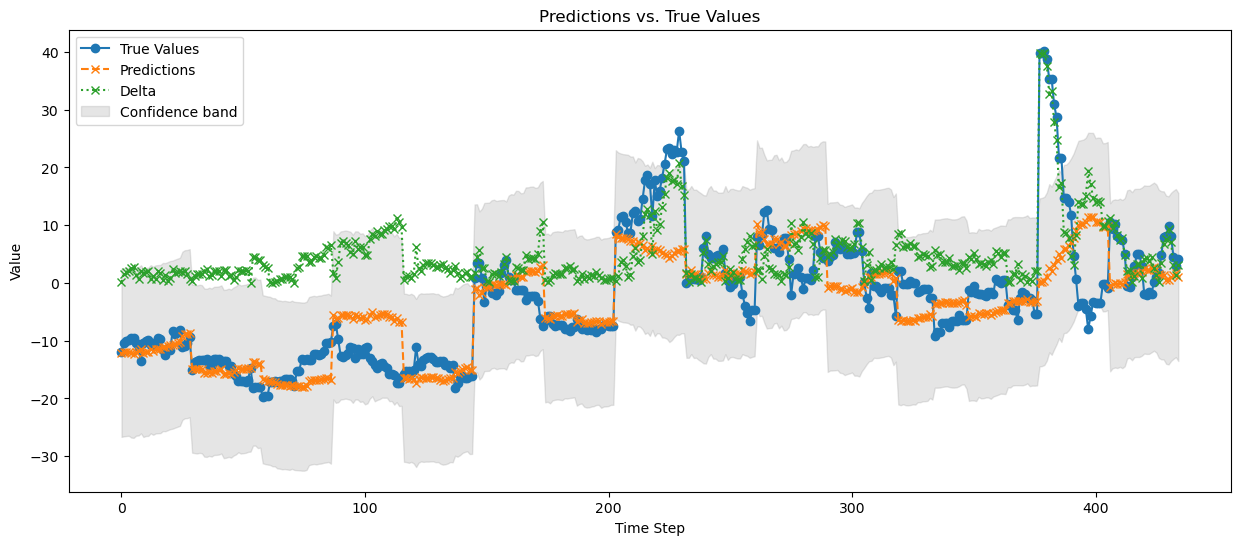

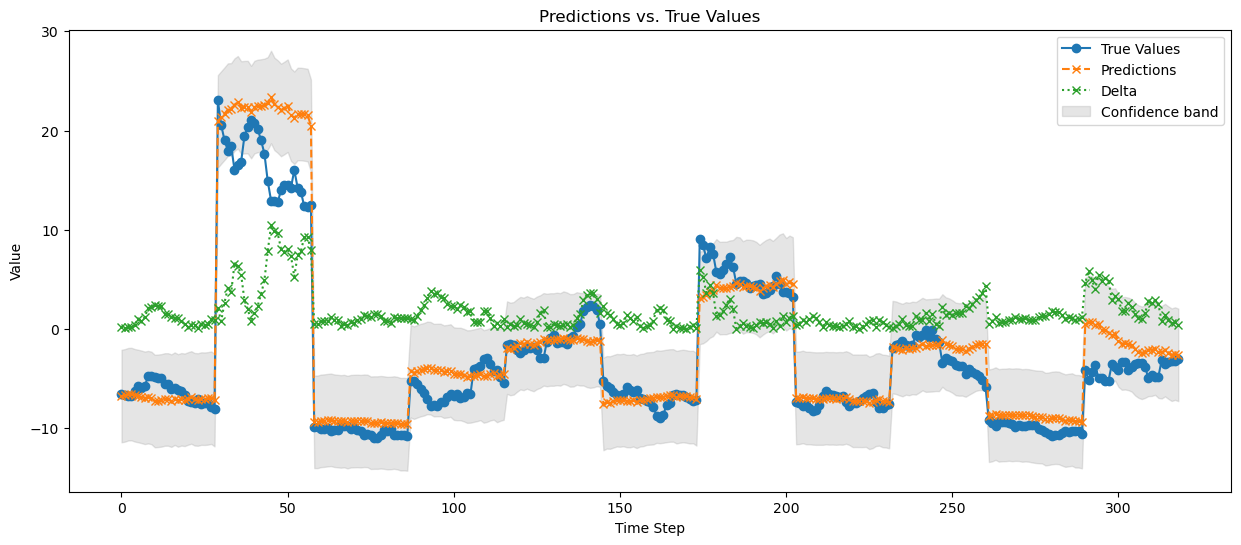

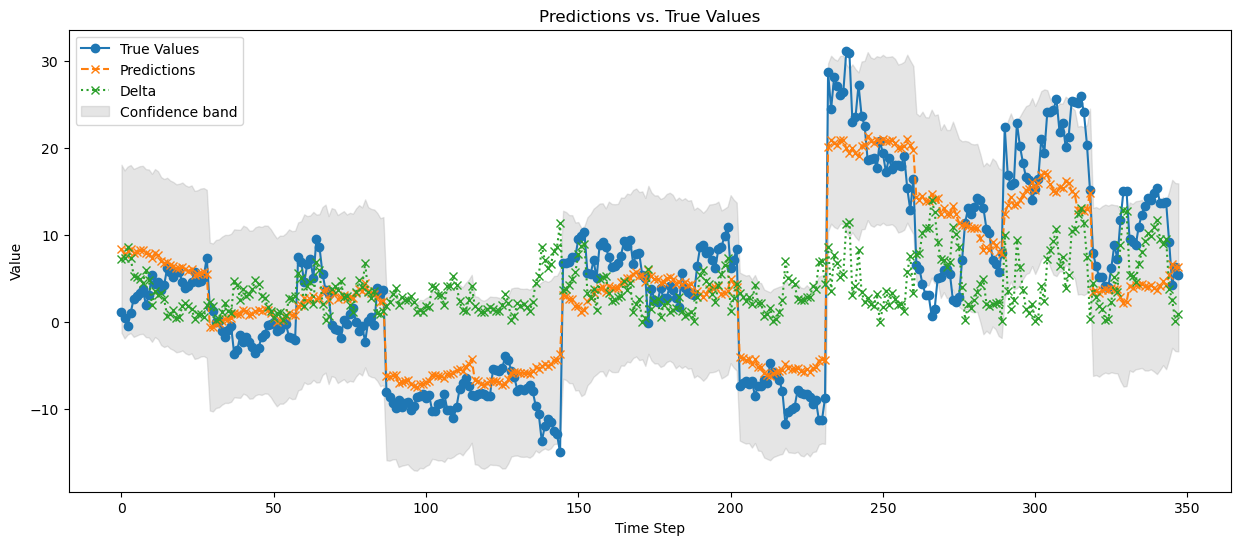

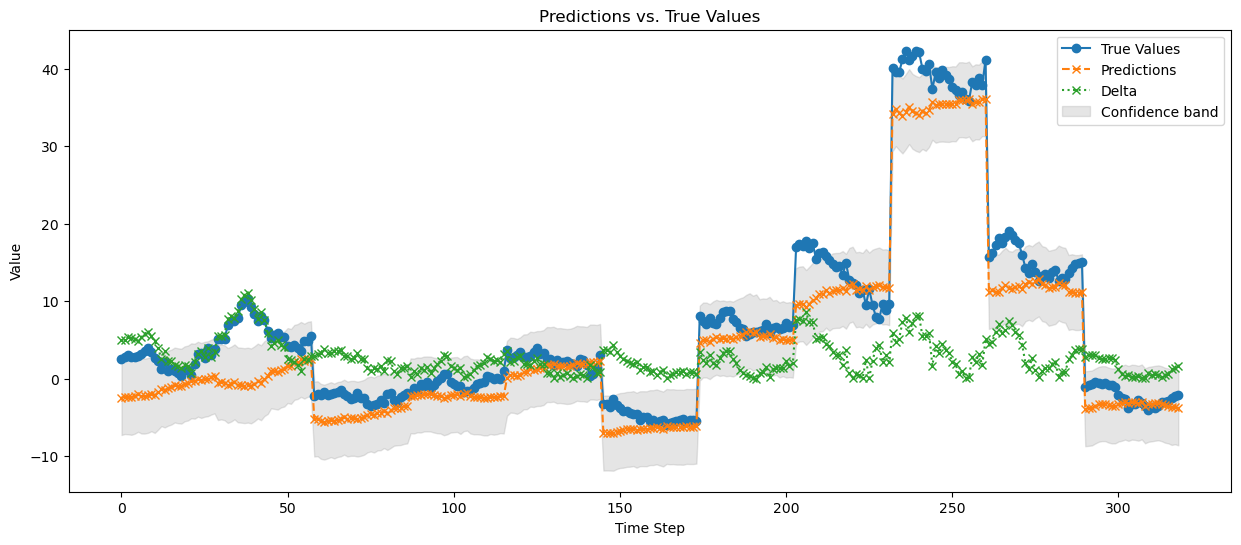

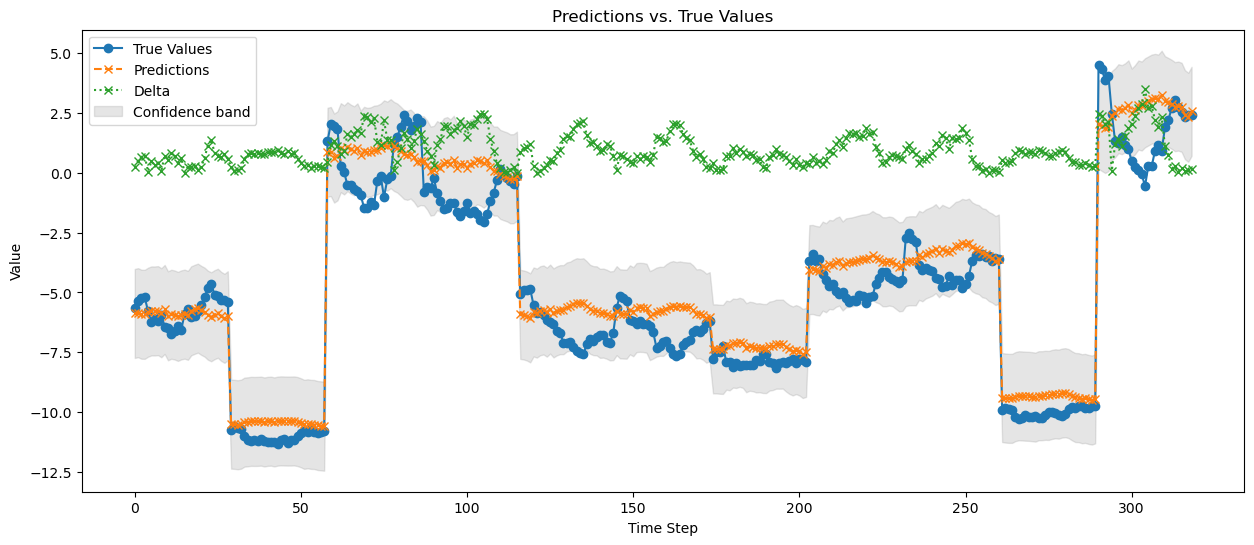

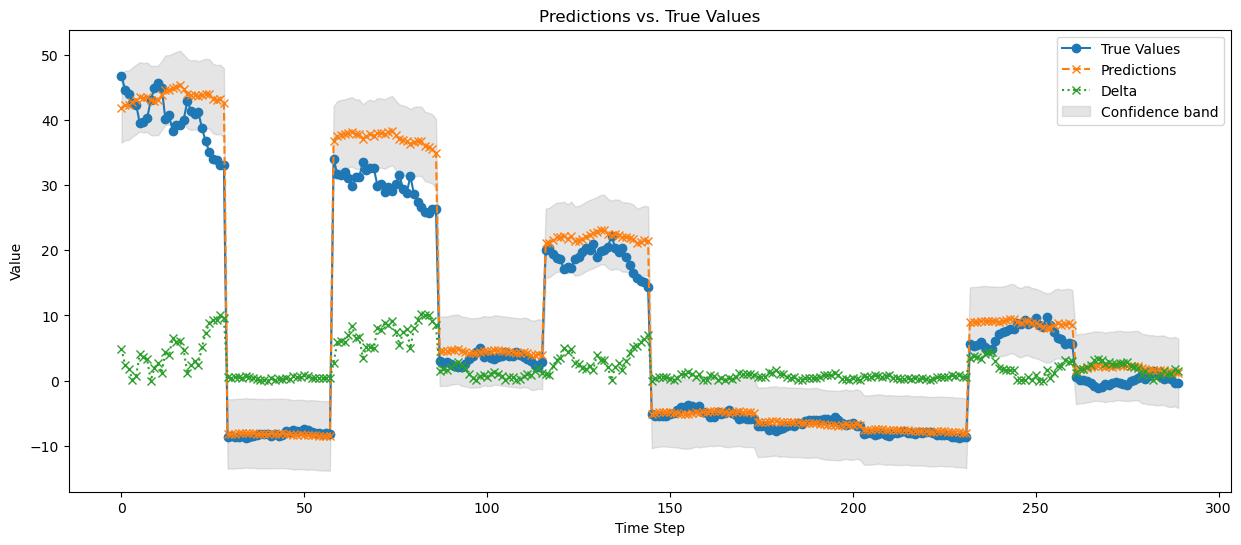

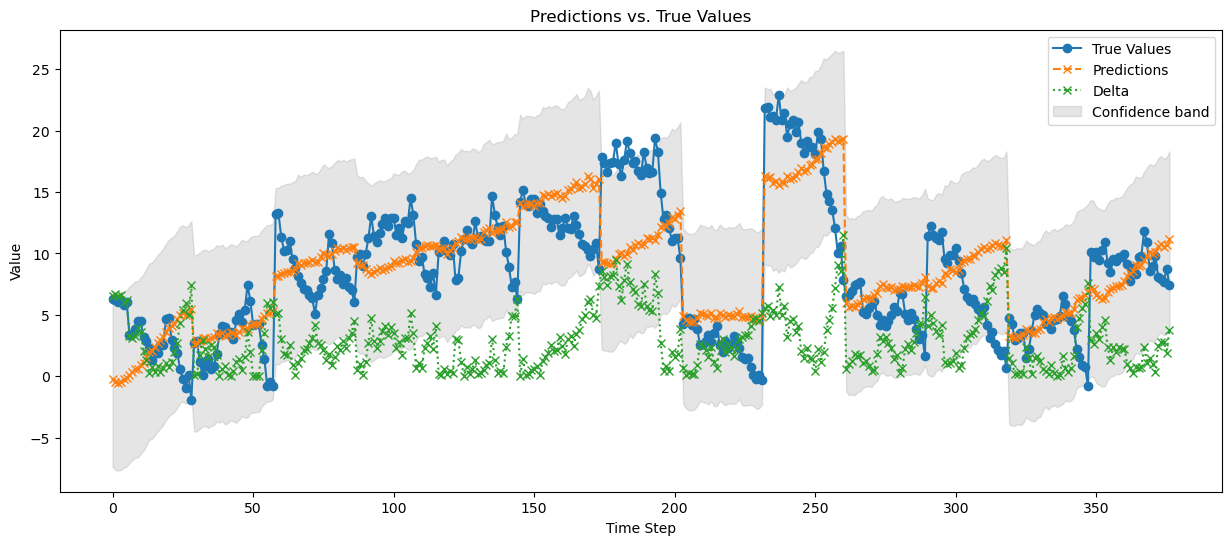

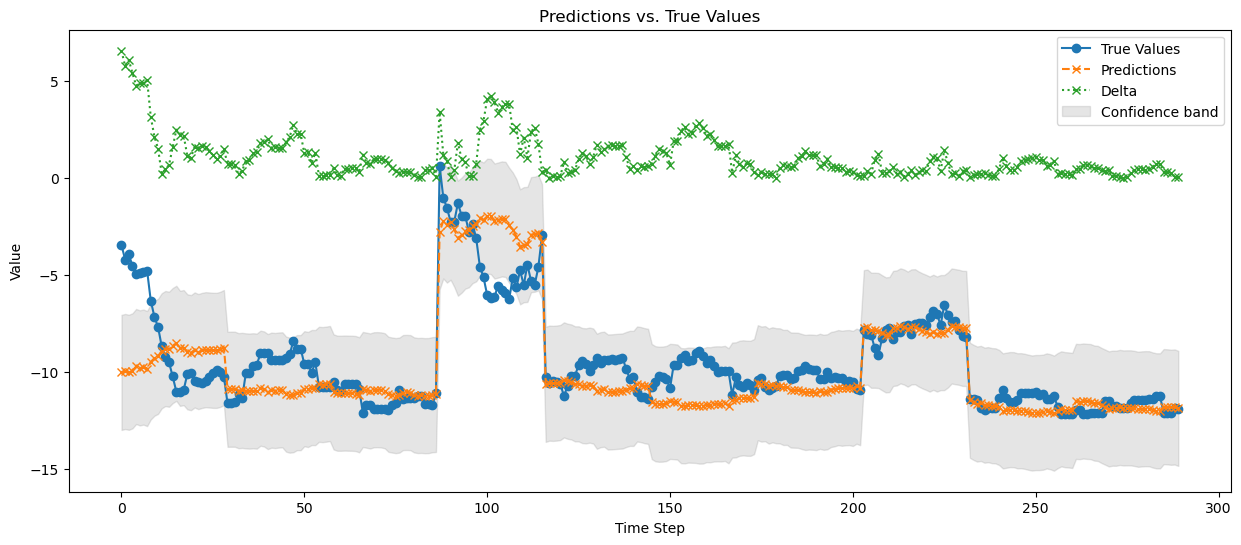

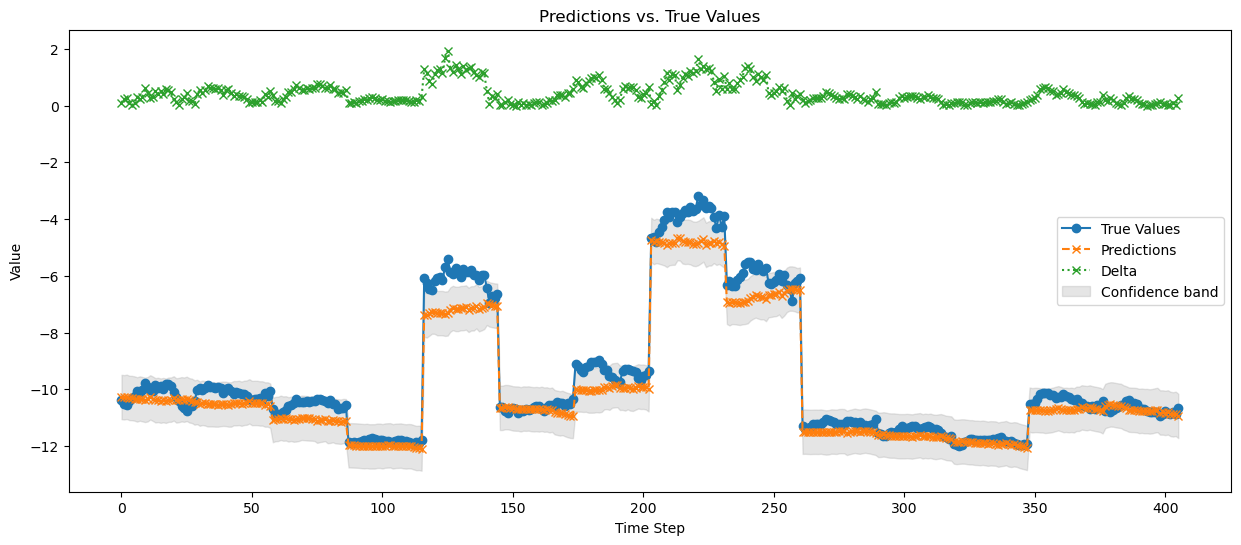

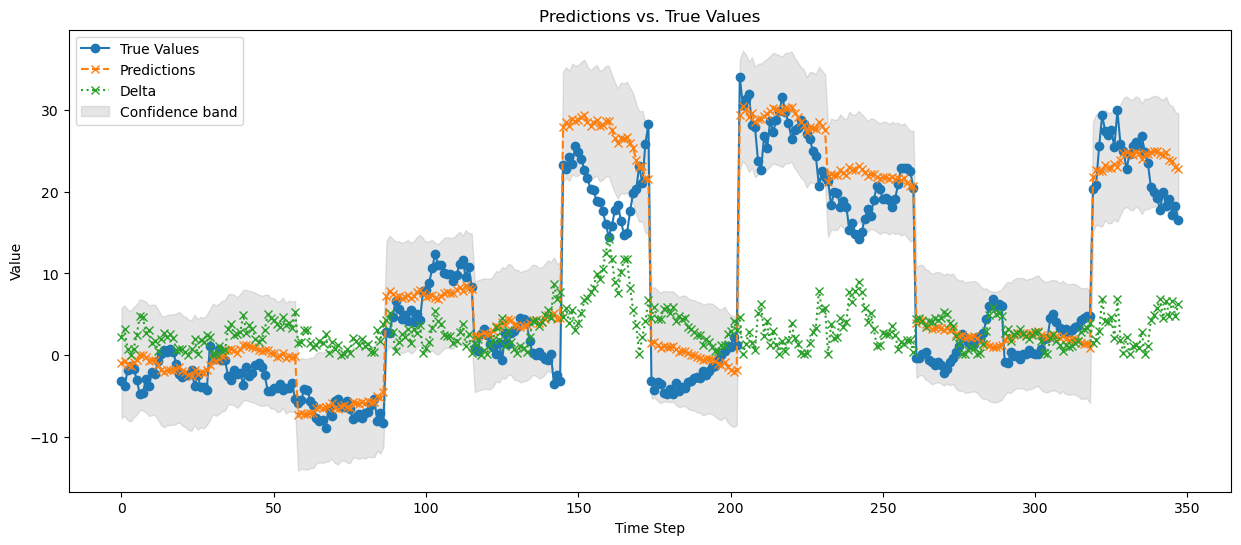

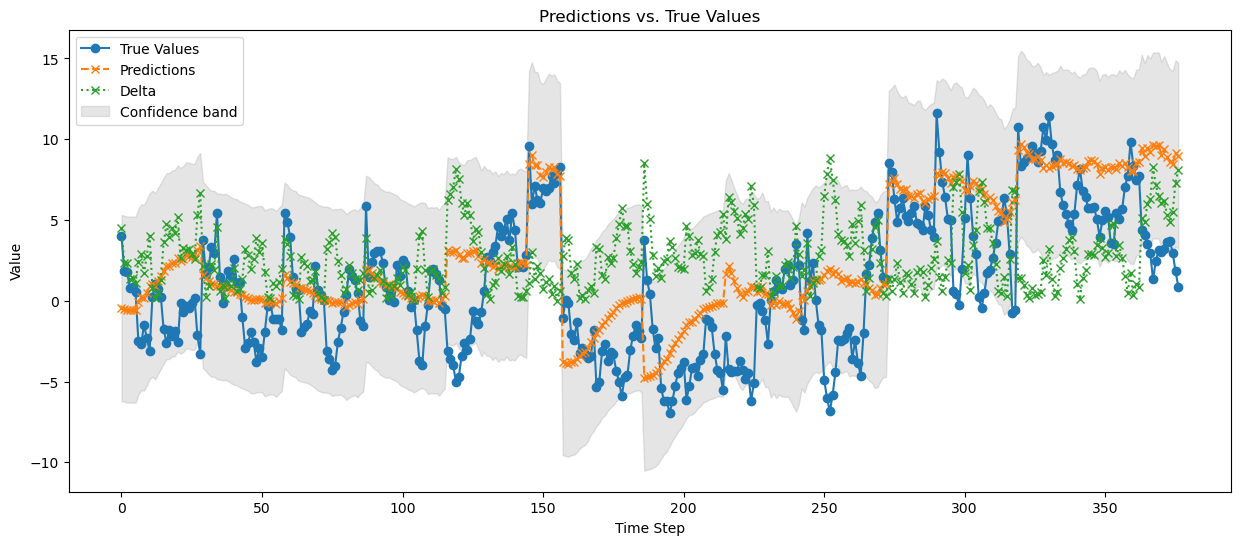

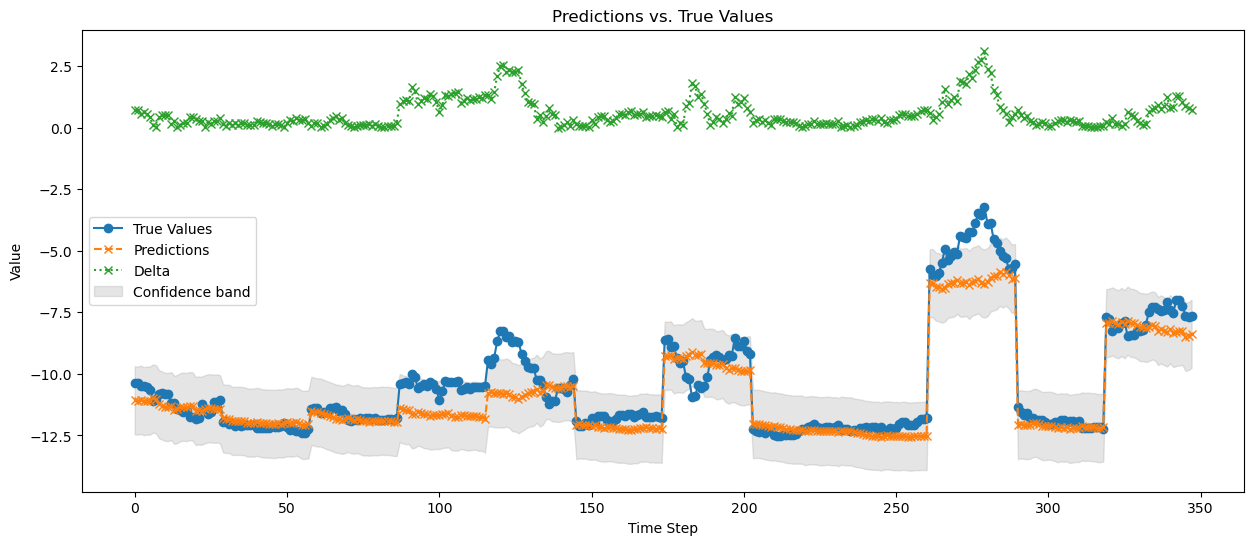

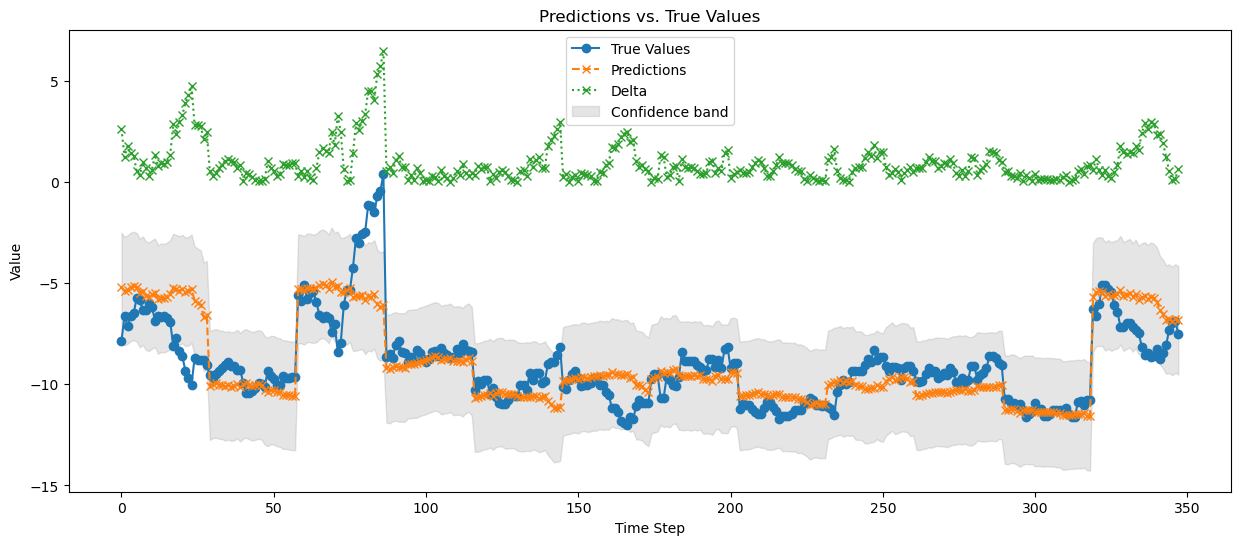

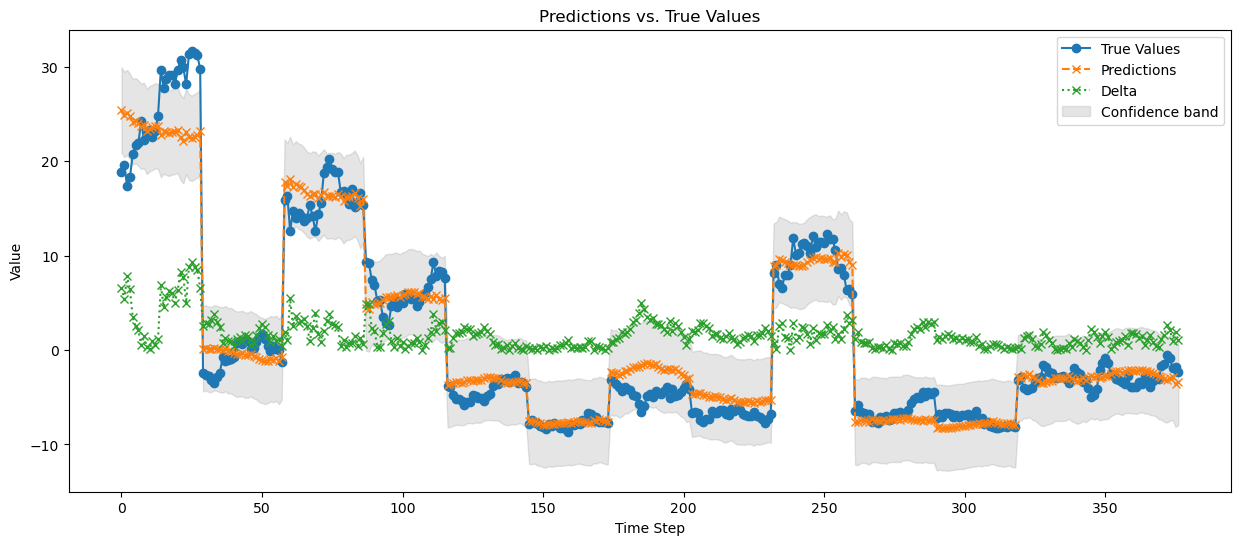

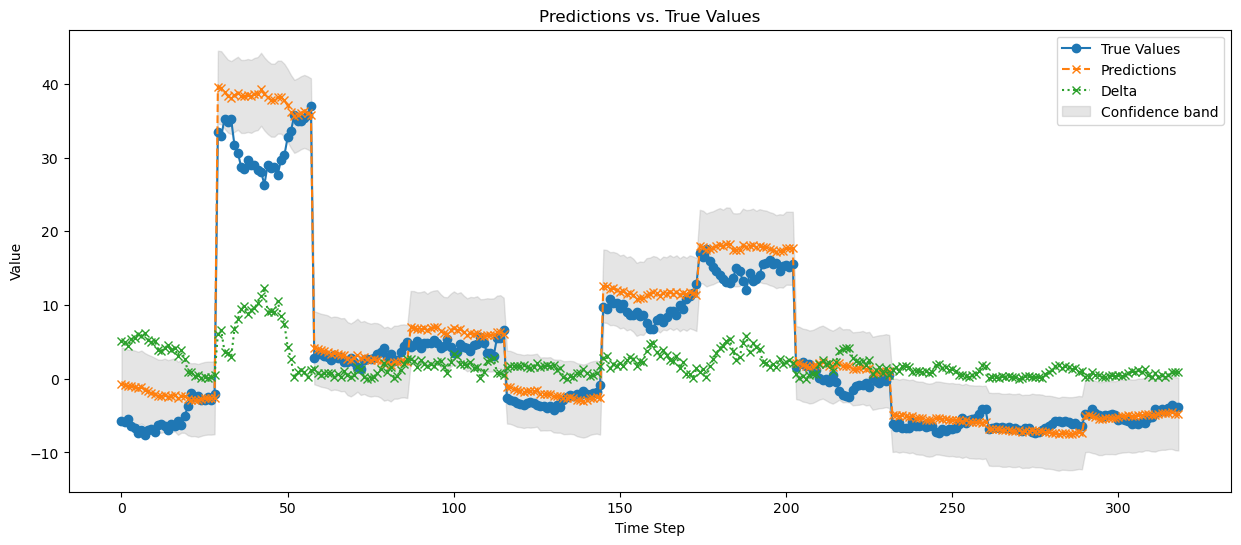

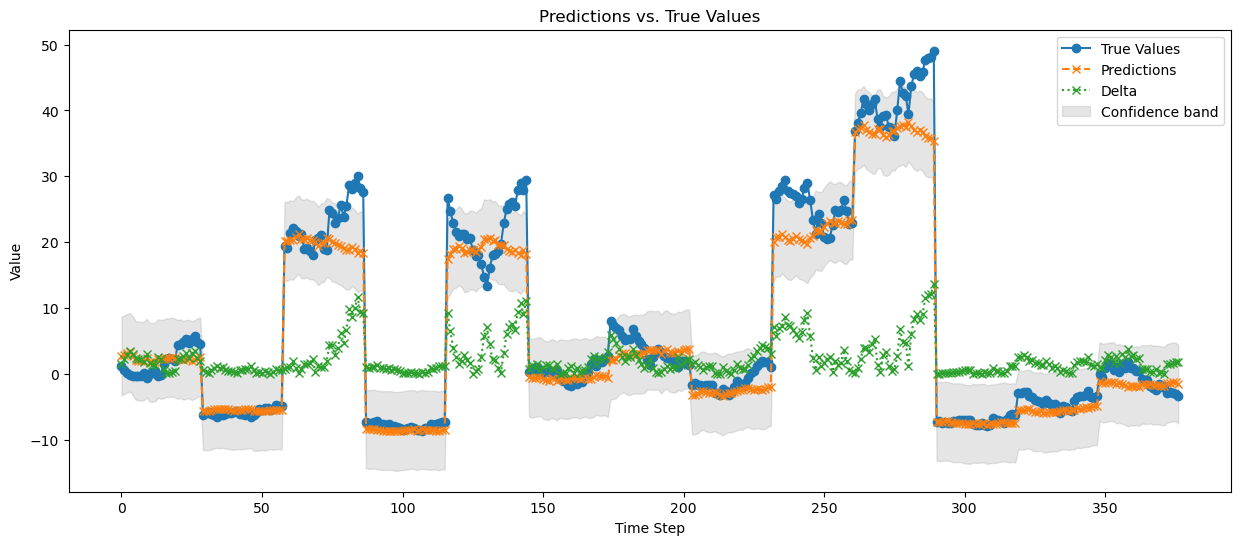

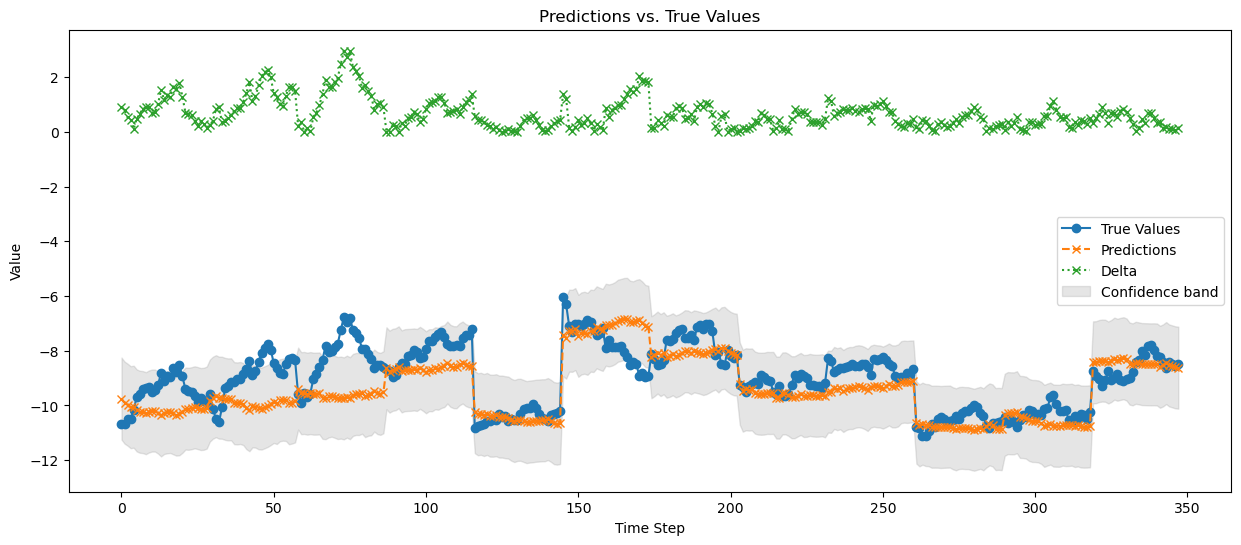

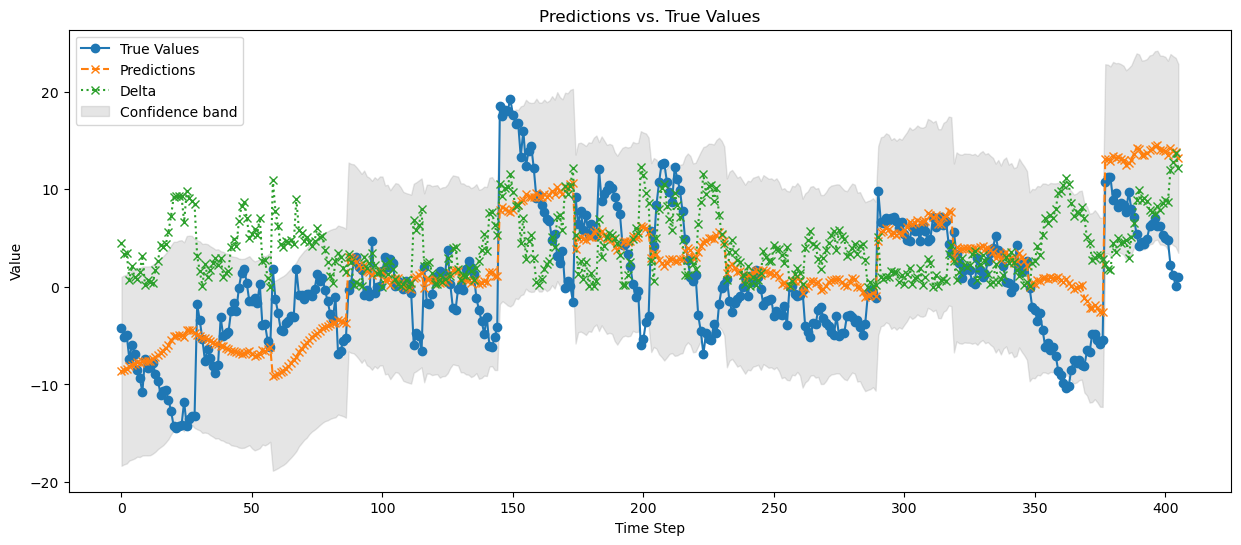

In [46]:
d_preds = list(d_preds.items())
random.shuffle(d_preds)
d_preds = dict(d_preds)
n = 0
plt.rcParams["figure.figsize"] = (15, 6)
for idx, (k, v) in enumerate(d_preds.items()):
    _v = pd.DataFrame(v)
    if len(_v["flatten_y"].unique()) <= 3:
        continue
    _v["delta"] = abs(_v["flatten_preds"] - _v["flatten_y"])
    x = range(0, len(_v))
    lower_bound, upper_bound = calculate_confidence_intervals(
        _v["flatten_preds"].values, _v["flatten_y"].values
    )
    plt.plot(x, _v["flatten_y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, _v["flatten_preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, _v["delta"], label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidence band"
    )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()

    n += 1
    if n >= 30:
        break

In [ ]:
_v = pd.DataFrame(v)
n = 0
for _, row in _v.iterrows():
    x = list(range(len(row["y"])))
    lower_bound, upper_bound = calculate_confidence_intervals(row["preds"], row["y"])
    delta = abs(row["preds"] - row["y"])
    plt.plot(x, row["y"], label="True Values", marker="o", linestyle="-")
    plt.plot(x, row["preds"], label="Predictions", marker="x", linestyle="--")
    plt.plot(x, delta, label="Delta", marker="x", linestyle=":")
    plt.fill_between(
        x, lower_bound, upper_bound, alpha=0.2, color="grey", label="Confidenze band"
    )

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Predictions vs. True Values")
    plt.legend()
    plt.show()
    n += 1
    if n >= 20:
        break